# Bayesian Logistic Regression for German Credit Data Set

We perform logistic regression with mean-zero Gaussian prior for the 24-dimensional *German credit data set*, as can be retrieved [here](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data), normalized so that all but the one-hot-encoded features have sample mean zero and sample variance one.

Denote the data set as $(a^{(i)},b^{(i)})_{i=1,...,n_{\text{data}}} \subset \mathbb{R}^d \times \{-1,1\}$, where $d = 25$, $n_{\text{data}} = 1000$ and where have padded the data by $a^{(i)}_d := 1 \; \forall i$ to enable an intercept.
Our prior is the mean-zero Gaussian $\mathcal{N}_d(0, \sigma^2 I_d)$ with $\sigma^2 = 100$. The likelihood is obtained by the usual logistic regression model. Our target density, the (unnormalized) posterior density, is therefore given by
$$
\varrho(x)
= \mathcal{N}_d(x; 0, \sigma^2 I_d) \prod_{i=1}^{n_{\text{data}}} \frac{1}{1 + \exp(-b^{(i)} \langle a^{(i)}, x \rangle)} , 
\quad x \in \mathbb{R}^d .
$$

In [1]:
from patt_mcmc import patt_ess, patt_gpss
from hit_and_run_uniform_slice_sampling import parallel_hruss
from random_walk_metropolis import parallel_ada_rwm
from generalized_elliptical_slice_sampling import two_group_gess
import stan_utils as su
import mcmc_utils as mcu
import plotting_functions as pfs

In [2]:
import pandas as pd
import numpy as np
import numpy.random as rnd
import time as tm
import matplotlib.pyplot as plt
import seaborn as sb

In [3]:
path_prefix = "../plots/BLR_German_credit_"

### Retrieve and Prepare the Data, do Feature Engineering, Construct the Target Density

In [4]:
# load data set from file
data = pd.read_table("../data/german_credit_data_numeric.txt", header=None, delim_whitespace=True)
data.columns = ["feature {}".format(i+1) for i in range(data.shape[1]-1)] + ["label"]
data

,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9,feature 10,...,feature 16,feature 17,feature 18,feature 19,feature 20,feature 21,feature 22,feature 23,feature 24,label
0,1,6,4,12,5,5,3,4,1,67,...,0,0,1,0,0,1,0,0,1,1
1,2,48,2,60,1,3,2,2,1,22,...,0,0,1,0,0,1,0,0,1,2
2,4,12,4,21,1,4,3,3,1,49,...,0,0,1,0,0,1,0,1,0,1
3,1,42,2,79,1,4,3,4,2,45,...,0,0,0,0,0,0,0,0,1,1
4,1,24,3,49,1,3,3,4,4,53,...,1,0,1,0,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4,12,2,17,1,4,2,4,1,31,...,0,0,1,0,0,1,0,1,0,1
996,1,30,2,39,1,3,1,4,2,40,...,0,1,1,0,0,1,0,0,0,1
997,4,12,2,8,1,5,3,4,3,38,...,0,0,1,0,0,1,0,0,1,1
998,1,45,2,18,1,3,3,4,4,23,...,0,0,1,0,0,0,0,0,1,2


In [5]:
# retrieve features, normalize all but the one-hot-encoded (ohe) features to mean zero and variance one,
# append a unit feature to enable intercept
n_data = data.shape[0]
features = data.drop('label', axis=1).to_numpy()
non_ohe = np.array([np.unique(features[:,i]).shape[0] > 2 for i in range(features.shape[1])], dtype=int)
trf_mean = non_ohe * np.mean(features, axis=0) + (1-non_ohe) * np.min(features, axis=0)
trf_std = non_ohe * np.std(features, axis=0) + (1-non_ohe)
normalized_features = (features - trf_mean) / trf_std
a = np.hstack([normalized_features, np.ones((n_data,1))])

In [6]:
# retrieve labels (1 = good, 2 = bad), map them to +-1
b = 2 * data['label'].to_numpy() - 3

In [7]:
# set/retrieve some general parameters
d = a.shape[1]
sig_sq = 100 # prior variance

In [8]:
# construct posterior
def log_density(x):
    return - np.sum(x**2) / (2 * sig_sq) - np.sum(np.log(1 + np.exp(-b * np.inner(a, x))))

#### Special Treatment for Stan

In [9]:
stan_code = su.BLR_CODE
stan_data = su.blr_data(n_data, d, a, b, np.sqrt(sig_sq))

In [10]:
su.prevent_crashes(stan_code, stan_data)

Building: found in cache, done.
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100% (1/1)
Sampling: 100% (1/1), done.
Messages received during sampling:
  Gradient evaluation took 6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.6 seconds.
  Adjust your expectations accordingly!
           performed for num_warmup < 20


### Run the Samplers

In running the samplers, we try to allocate each of them roughly the same computational budget. Regardless of how many iterations a sampler performs and how many parallel chains it uses, we ultimately judge it solely by its performance in the latter half of all of its chains.

Note: If either PATT or GESS is run before HRUSS and AdaRWM, it can break the latter's progress bars, likely due to some sort of incompatibility between tqdm.tqdm and tqdm.notebook.tqdm.

In [11]:
n_chains = 10 # number of parallel chains permitted to each sampler (except GESS)
n_its = int(2e4) # total number of iterations per chain, per sampler (except AdaRWM, GESS)
x_0s = rnd.normal(size=(n_chains,d)) # suggested initial states

#### Hit-and-Run Uniform Slice Sampling

In [12]:
w_hruss = 1.0

In [13]:
samples_hruss, tde_hruss, times_hruss = parallel_hruss(log_density, n_chains, n_its, x_0s, w_hruss)

Checking validity of given arguments...
Preparing for parallel sampling...
Starting parallel sampling...


100%|███████████████████████████████████| 20000/20000 [00:06<00:00, 3040.22it/s]


Processing returns and terminating...


#### Adaptive Random Walk Metropolis
Note: We grant AdaRWM significantly more iterations than its competitors because it has a much lower computational cost per iteration (by virtue of only using one TDE per iteration) and we intend to grant the different samplers roughly the same computational budget.

In [14]:
n_its_rwm = 5 * n_its

In [15]:
samples_rwm, times_rwm, ldv_rwm, means_rwm, cov_rwm = parallel_ada_rwm(log_density, n_chains, n_its_rwm, x_0s)

Checking validity of given arguments...
Preparing for parallel sampling...
Starting parallel sampling...


100%|█████████████████████████████████| 100000/100000 [00:12<00:00, 8168.46it/s]


Processing returns and terminating...


In [16]:
tde_rwm = np.ones((n_its_rwm+1,n_chains), dtype=int)

#### PATT Elliptical Slice Sampling

In [17]:
n_burn_ess = n_its // 10
n_its_ess = n_its - n_burn_ess

In [18]:
ret_dic = patt_ess(
    log_density,
    n_chains,
    n_burn_ess,
    n_its_ess,
    x_0s,
    cen_mode='mean',
    cov_mode='cov',
)

Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/18001 [00:00<?, ?it/s]

Assembling output...


In [19]:
samples_ess = np.vstack([ret_dic['burn-in'], ret_dic['samples'][1:]])
tde_ess = np.vstack([ret_dic['tde_cnts_burn'], ret_dic['tde_cnts'][1:]])
times_ess = np.vstack([ret_dic['runtimes_burn'], ret_dic['runtimes'][1:]])
means_ess = ret_dic['means']
covs_ess = ret_dic['covs']
schedule_ess = ret_dic['schedule']

#### PATT Gibbsian Polar Slice Sampling

In [20]:
n_burn_gpss = n_its // 10
n_its_gpss = n_its - n_burn_gpss
w_burn = 1.0
w_att = np.sqrt(d) / 2

In [21]:
ret_dic = patt_gpss(
    log_density,
    n_chains,
    n_burn_gpss,
    n_its_gpss,
    x_0s,
    cen_mode='mean',
    cov_mode='cov',
    w_burn=w_burn,
    w_att=w_att,
)

Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/18001 [00:00<?, ?it/s]

Assembling output...


In [22]:
samples_gpss = np.vstack([ret_dic['burn-in'], ret_dic['samples'][1:]])
tde_gpss = np.vstack([ret_dic['tde_cnts_burn'], ret_dic['tde_cnts'][1:]])
times_gpss = np.vstack([ret_dic['runtimes_burn'], ret_dic['runtimes'][1:]])
means_gpss = ret_dic['means']
covs_gpss = ret_dic['covs']
schedule_gpss = ret_dic['schedule']

#### Two-Group Generalized Elliptical Slice Sampling
Note: We grant GESS *way* more iterations than is appropriate with regards to our intent to allocate each method roughly the same computational budget. This is necessitated by GESS's demand for a very large number of chains on the one hand, and our desire to properly analyze the autocorrelation of each of these chains on the other hand.

In [23]:
n_chains_gess = max(2*d, n_chains)
n_its_gess = int(1e4)
x_0s_gess = rnd.normal(size=(2*n_chains_gess,d))

In [24]:
time_b = tm.time()
ret_dic = two_group_gess(log_density, n_chains_gess, 2 * n_its_gess, x_0s_gess, n_thr=n_chains)
time_a = tm.time()
total_time_gess = time_a - time_b

Checking validity of given arguments...
Preparing for parallel sampling...
Starting two-group sampling...


  0%|          | 0/20002 [00:00<?, ?it/s]

Assembling output...


In [25]:
samples_gess = ret_dic['samples']
tde_gess = ret_dic['tde_cnts']
schedule_gess = ret_dic['schedule']
dfs_G1, dfs_G2 = ret_dic['dfs']
centers_G1, centers_G2 = ret_dic['centers']
centers_gess = np.concatenate([centers_G1.reshape(-1,1,d), centers_G2.reshape(-1,1,d)], axis=1)
scale_G1, scale_G2 = ret_dic['scales']

#### Stan's NUTS

In [26]:
time_b = tm.time()
frames_stan, samples_stan, tge_stan, acc_rates_stan \
= su.sample_in_parallel(stan_code, stan_data, n_chains, n_its, x_0s)
time_a = tm.time()
total_time_stan = time_a - time_b

Building: found in cache, done.
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Building: found in cache, done.
Building: found in cache, done.
Messages from stanc:
Building: found in cache, done.
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Building: found in cache, done.
Building: found in cache, done.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Building: found in cache, done.
Messages from stanc:
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Messages from stanc:
Building: found in cache, done.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Messages from stanc:
    provided, or the prior(s) depend on data variabl

  Adjust your expectations accordingly!
Sampling: 100% (21000/21000)
Sampling: 100% (21000/21000), done.
Messages received during sampling:
  Gradient evaluation took 4.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.44 seconds.
  Adjust your expectations accordingly!
Sampling: 100% (21000/21000)
Sampling: 100% (21000/21000)
Sampling: 100% (21000/21000), done.
Messages received during sampling:
  Gradient evaluation took 4.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.47 seconds.
  Adjust your expectations accordingly!
Sampling: 100% (21000/21000), done.
Messages received during sampling:
  Gradient evaluation took 6.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.62 seconds.
  Adjust your expectations accordingly!
Sampling: 100% (21000/21000)
Sampling: 100% (21000/21000)
Sampling: 100% (21000/21000), done.
Messages received during sampling:
  Gradient evaluation took 9e-05 

In [27]:
frames_stan[0]

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,x.1,x.2,x.3,...,x.16,x.17,x.18,x.19,x.20,x.21,x.22,x.23,x.24,x.25
draws,,,,,,,,,,,,,,,,,,,,,
0,-475.172286,0.829019,0.113563,5.0,31.0,0.0,494.265295,-0.624344,0.536880,-0.435404,...,0.620729,-1.063749,0.971786,1.099393,0.378055,-0.302349,-0.367363,0.025176,0.062950,-1.908291
1,-475.713658,0.994162,0.113563,5.0,31.0,0.0,489.362131,-0.839635,0.403855,-0.395293,...,0.554621,-1.053509,1.168399,1.573092,0.514548,0.105576,-1.104970,-0.035490,0.015571,-2.257075
2,-478.541260,0.949673,0.113563,5.0,63.0,0.0,491.245355,-0.670583,0.519183,-0.468103,...,0.923228,-0.499929,2.043663,2.654720,0.590931,0.166272,-0.526538,-0.105490,-0.330638,-3.315530
3,-483.780178,0.863988,0.113563,5.0,63.0,0.0,495.552773,-0.733270,0.442164,-0.510178,...,0.837818,-0.974364,1.893988,2.734658,0.287091,0.158231,0.109887,-0.354471,-0.220651,-2.830622
4,-480.187829,0.994438,0.113563,5.0,31.0,0.0,491.309373,-0.813769,0.410955,-0.338059,...,0.671246,-1.008131,1.211482,1.473238,0.358580,-0.257170,-1.223752,0.481289,0.043716,-2.193952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,-477.982766,0.986052,0.113563,5.0,31.0,0.0,494.158992,-0.850851,0.337873,-0.450171,...,0.680546,-0.967722,1.353993,1.952052,-0.015725,-0.445673,-0.576586,0.272195,0.350547,-2.461114
19996,-480.301968,0.994224,0.113563,5.0,31.0,0.0,489.347484,-0.658693,0.449814,-0.383069,...,0.748960,-0.475312,2.021061,2.524506,0.604813,0.033751,-0.726375,0.287698,0.132507,-3.230376
19997,-477.764829,0.931590,0.113563,5.0,31.0,0.0,491.695591,-0.734694,0.329574,-0.341188,...,0.969526,-0.841751,1.865955,2.059425,0.756487,0.220651,-0.660362,-0.057748,0.197605,-3.491004


### Analyze Sampling Performance

In [28]:
snames = ["PATT-ESS", "PATT-GPSS", "HRUSS", "AdaRWM", "GESS", "Stan's NUTS"]
nsam = len(snames)
full_samples = [samples_ess, samples_gpss, samples_hruss, samples_rwm, samples_gess, samples_stan]
full_tde = [tde_ess, tde_gpss, tde_hruss, tde_rwm, tde_gess, tge_stan]
full_times = [times_ess, times_gpss, times_hruss, times_rwm, None, None] # this list...
full_total_times = [None, None, None, None, total_time_gess, total_time_stan] # ...should complement this list
n_chains_all = np.full(nsam, n_chains)
n_chains_all[4] = n_chains_gess # make sure index 4 <-> GESS!
n_its_all = np.array([n_its, n_its, n_its, n_its_rwm, n_its_gess, n_its], dtype=int)
n_burns = n_its_all // 2
n_late_its = n_its_all - n_burns
n_late_samples = n_chains_all * n_late_its

In [29]:
burn_samples = [fs[:nb] for fs, nb in zip(full_samples, n_burns)]
samples = [fs[nb:] for fs, nb in zip(full_samples, n_burns)]
burn_tde = [ft[:nb] for ft, nb in zip(full_tde, n_burns)]
tde = [ft[nb:] for ft, nb in zip(full_tde, n_burns)]
burn_times = [ft[:nb] if type(ft) != type(None) else None for ft, nb in zip(full_times, n_burns)]
times = [ft[nb:] if type(ft) != type(None) else None for ft, nb in zip(full_times, n_burns)]
full_radii = mcu.get_radii_list(full_samples)
burn_radii = mcu.get_radii_list(burn_samples)
radii = mcu.get_radii_list(samples)
flat_steps = mcu.get_flat_steps_list(samples)
pos_mean_ests = [np.mean(sams, axis=(0,1)) for sams in samples]

In [30]:
# collect total runtimes taken by each sampler for the "late" iterations
total_times = np.zeros(nsam)
for i in range(nsam):
    if type(times[i]) != type(None):
        total_times[i] = np.mean(np.sum(times[i], axis=0))
    else:
        total_times[i] = full_total_times[i] * (n_late_its[i] / n_its_all[i])

In [31]:
mean_burn_tde = mcu.mean_tde_list(burn_tde)
mean_tde = mcu.mean_tde_list(tde)
sams_per_s = n_late_samples / total_times
maxls = [1000, 1000, 5000, 2500, 1000, 1000]
mean_iats = mcu.mean_iat_multi_chain_list(samples, maxls)
msss = mcu.mss_list(samples)
tde_per_es = mean_tde * mean_iats # TDE/ES = total TDE / total ES = TDE/it / ES/it = TDE/it * IAT
es_per_s = sams_per_s / mean_iats # ES/s = total ES / total time = (total samples / IAT) / total time = samples/time / IAT
accuracy = lambda coef: np.mean(np.sign(np.inner(a, coef)) == b)
accuracies = [accuracy(pme) for pme in pos_mean_ests]

In [32]:
pd.DataFrame(
    np.array([
        snames,
        np.round(mean_burn_tde, 2),
        np.round(mean_tde, 2),
        np.array(sams_per_s, dtype=int),
        np.round(mean_iats, 2),
        np.round(msss, 2),
        np.round(tde_per_es, 2),
        np.round(es_per_s, 2),
        np.round(mean_tde / msss, 2), # = TDE/it * (its to move by 1) = TDE to move by 1
        np.round(accuracies, 3),
    ]).T,
    columns = [
        "Sampler",
        "Burn-In TDE/it",
        "TDE/it",
        "Samples/s",
        "Mean IAT",
        "MSS",
        "TDE/ES",
        "ES/s",
        "TDE/MSS",
        "Accuracy",
    ]
)

,Sampler,Burn-In TDE/it,TDE/it,Samples/s,Mean IAT,MSS,TDE/ES,ES/s,TDE/MSS,Accuracy
0,PATT-ESS,3.31,1.27,38005,1.42,1.77,1.8,26792.51,0.72,0.785
1,PATT-GPSS,7.95,6.11,18332,1.24,1.81,7.57,14801.03,3.39,0.786
2,HRUSS,5.2,5.21,36850,425.88,0.11,2220.89,86.53,46.97,0.786
3,AdaRWM,1.0,1.0,90467,191.07,0.1,191.07,473.48,10.25,0.785
4,GESS,6.92,4.74,8623,83.35,0.65,394.74,103.45,7.25,0.788
5,Stan's NUTS,39.19,39.21,4744,1.29,1.93,50.73,3667.39,20.35,0.786


### Plotting

In [33]:
n_win = int(5e3)

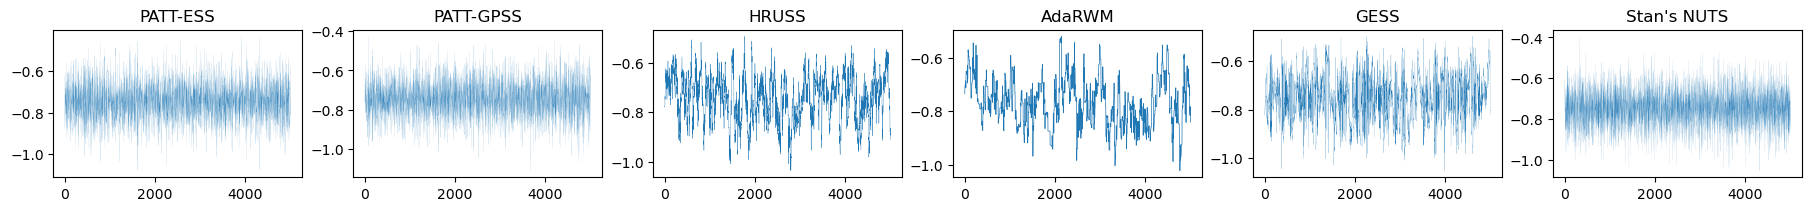

In [34]:
lws = [0.05, 0.05, 0.25, 0.5, 0.1, 0.05]
path = path_prefix + "marginal_trace.png"
pfs.trace_plot_row([sams[-n_win:,0,0] for sams in samples], snames, filepath=path, lws=lws)

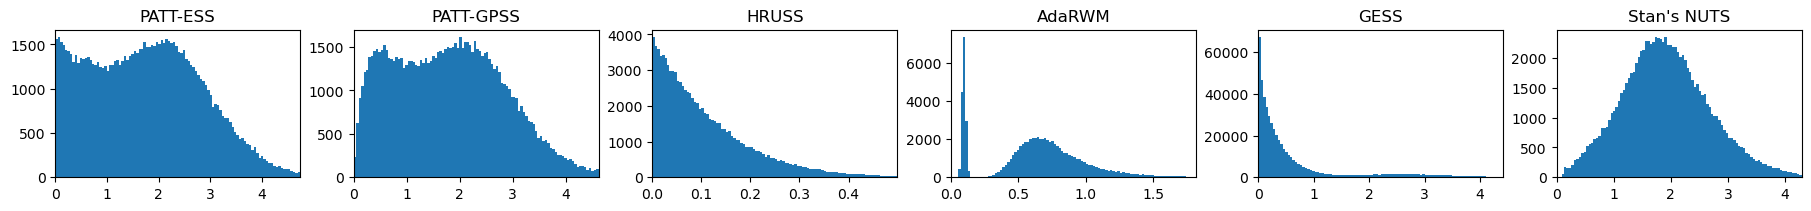

In [35]:
plot_steps = [np.copy(fs) for fs in flat_steps]
plot_steps[3] = plot_steps[3][plot_steps[3] != 0.0]
path = path_prefix + "steps.png"
pfs.plot_step_hist_row(plot_steps, snames, filepath=path)

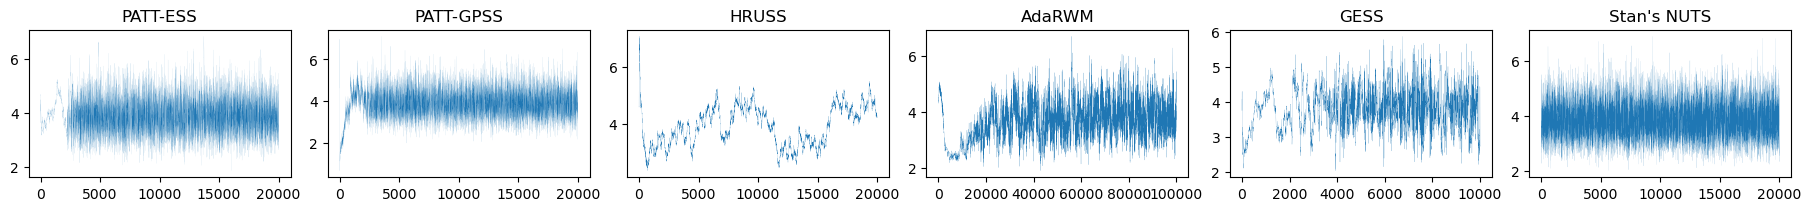

In [36]:
lws = [0.0375, 0.0375, 0.1, 0.1, 0.1, 0.05]
pfs.trace_plot_row([frs[:,0] for frs in full_radii], snames, lws=lws)

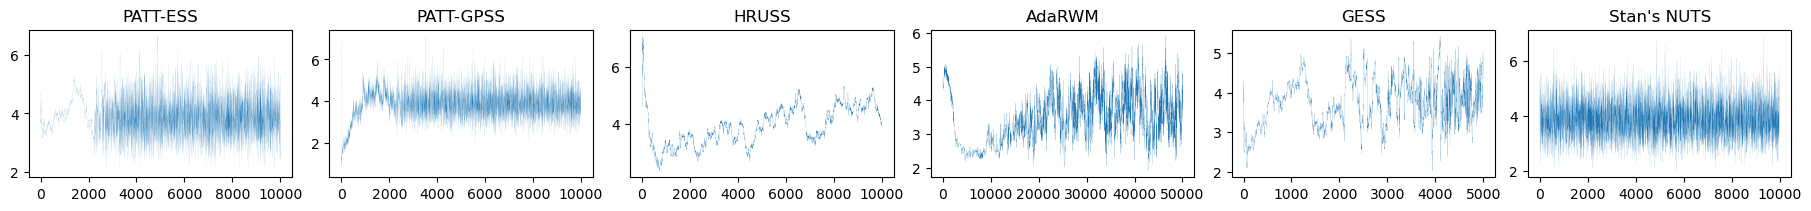

In [37]:
pfs.trace_plot_row([brs[:,0] for brs in burn_radii], snames, lws=lws)

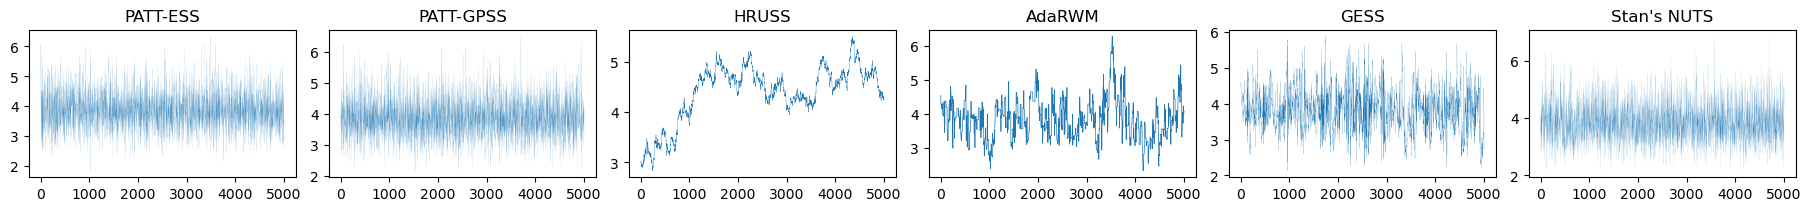

In [38]:
lws = [0.05, 0.05, 0.25, 0.5, 0.1, 0.05]
pfs.trace_plot_row([rs[-n_win:,0] for rs in radii], snames, lws=lws)

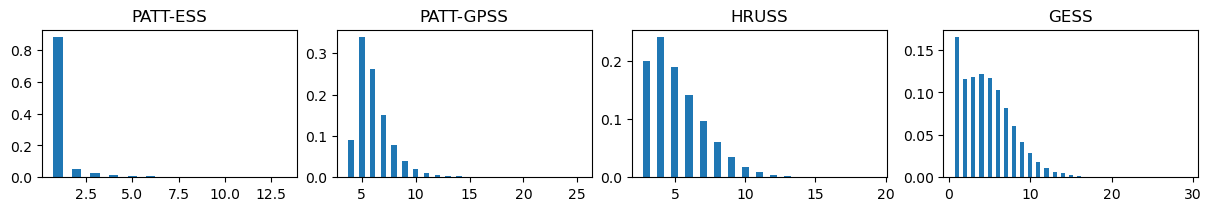

In [39]:
tde_inds = [0,1,2,4]
pfs.plot_tde_distr_row([tde[i] for i in tde_inds], [snames[i] for i in tde_inds])

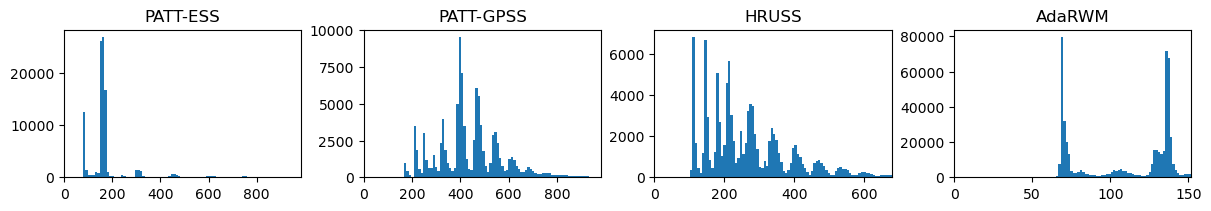

In [40]:
granular_times = [0,1,2,3]
pfs.plot_runtime_hist_row([times[i] for i in granular_times], 
                          [snames[i] for i in granular_times], nbins=100, cutoff_quant=0.99)

In [41]:
acc_rates_rwm = np.mean(ldv_rwm[n_its_rwm//2+1:] != ldv_rwm[n_its_rwm//2:-1], axis=0)
print("Average AdaRWM acceptance rate: {:.3f}".format(np.mean(acc_rates_rwm)))
print("Minimal AdaRWM acceptance rate: {:.3f}".format(np.min(acc_rates_rwm)))
print("Maximal AdaRWM acceptance rate: {:.3f}".format(np.max(acc_rates_rwm)))

Average AdaRWM acceptance rate: 0.154
Minimal AdaRWM acceptance rate: 0.093
Maximal AdaRWM acceptance rate: 0.208


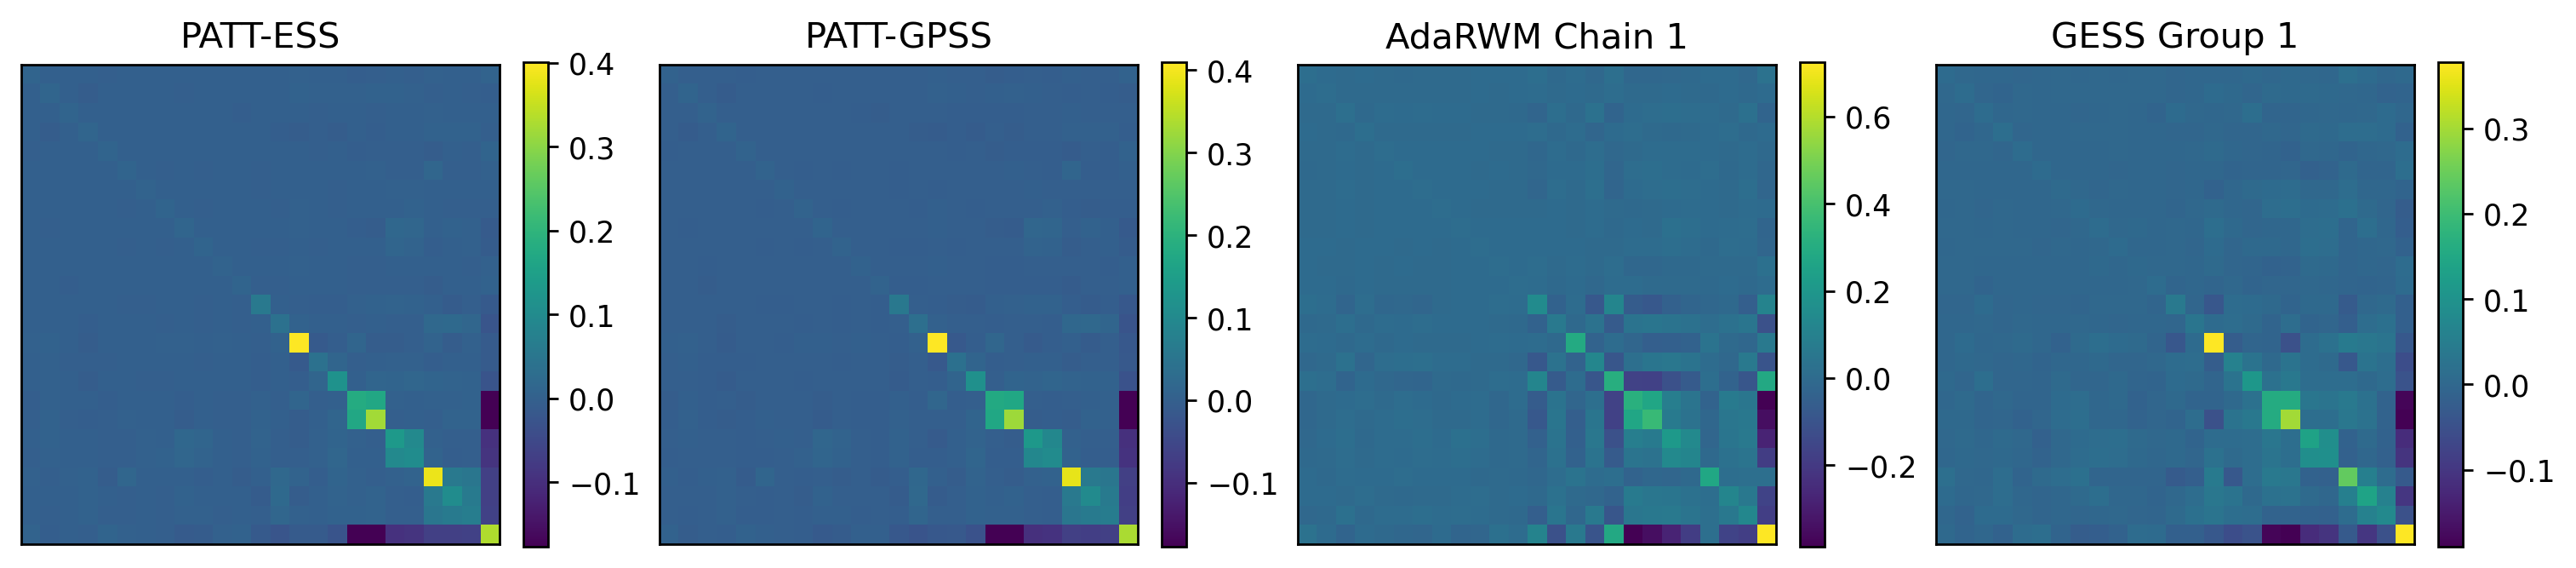

In [42]:
titles = ["PATT-ESS", "PATT-GPSS", "AdaRWM Chain 1", "GESS Group 1"]
covs = [covs_ess[-1], covs_gpss[-1], cov_rwm[0], scale_G1]
path = path_prefix + "covs.png"
pfs.plot_covs_row(covs, titles, filepath=path, shrink=0.78)

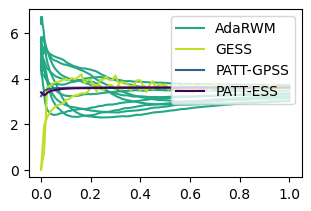

In [43]:
# plot progressions of the norm of each sampler's posterior mean approximation
norms_ess = mcu.get_radii(means_ess)
norms_gpss = mcu.get_radii(means_gpss)
norms_rwm = mcu.get_radii(means_rwm)
norms_gess = mcu.get_radii(centers_gess)
colors = plt.cm.viridis(np.linspace(0, 0.9, 4))
pfs.initiate((3,2),100)
plt.plot(np.linspace(0,1,n_its_rwm+1), norms_rwm[:,0], color=colors[2], label=snames[3])
for i in range(1,n_chains):
    plt.plot(np.linspace(0,1,n_its_rwm+1), norms_rwm[:,i], color=colors[2])
plt.plot(schedule_gess / schedule_gess[-1], norms_gess[:,0], color=colors[3], label=snames[4])
plt.plot(schedule_gess / schedule_gess[-1], norms_gess[:,1], color=colors[3])
plt.plot(schedule_gpss / schedule_gpss[-1], norms_gpss, color=colors[1], label=snames[1])
plt.plot(schedule_ess / schedule_ess[-1], norms_ess, color=colors[0], label=snames[0])
plt.legend(loc='upper right')
pfs.wrapup()

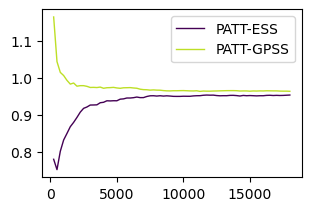

In [44]:
# plot progressions of the norm of the PATT samplers' posterior covariance approximations
cov_norms_ess = mcu.get_radii(covs_ess.reshape(schedule_ess.shape[0],-1))
cov_norms_gpss = mcu.get_radii(covs_gpss.reshape(schedule_gpss.shape[0],-1))
colors = plt.cm.viridis(np.linspace(0, 0.9, 2))
pfs.initiate((3,2),100)
plt.plot(schedule_ess[1:], cov_norms_ess[1:], color=colors[0], linewidth=1)
plt.plot(schedule_gpss[1:], cov_norms_gpss[1:], color=colors[1], linewidth=1)
plt.legend(snames[:2])
pfs.wrapup()

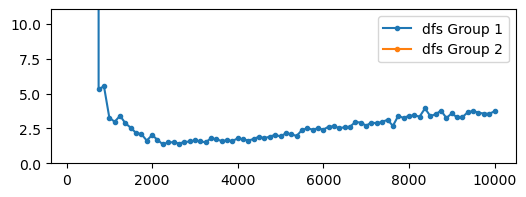

In [45]:
plt.figure(figsize=(6,2))
for dfs in [dfs_G1, dfs_G2]:
    plt.plot(schedule_gess[1:], dfs[1:], marker='.')
plt.legend(["dfs Group {}".format(i+1) for i in range(2)])
plt.ylim((0,2*np.max(np.concatenate([dfs_G1[dfs_G1 != 1e6], dfs_G2[dfs_G2 != 1e6]]))))
plt.show()

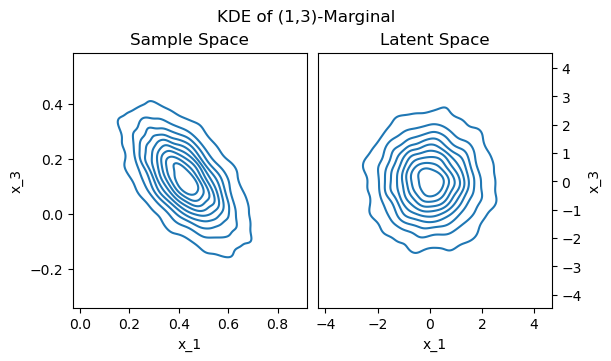

In [46]:
# plot a bivariate marginal KDE in sample space and (PATT-ESS's final) latent space
inds = [1,3]
ax_labels = ["x_{}".format(inds[0]), "x_{}".format(inds[1])]
fig, axes = plt.subplots(1,2, figsize=(6,3.5), dpi=100, constrained_layout=True)
fig.suptitle("KDE of ({},{})-Marginal".format(inds[0], inds[1]))
# left column: bivariate marginal in sample space
axes[0].set_title("Sample Space")
biv_sample_sp = np.concatenate([samples[0][:,0,inds[0]].reshape(-1,1),
                                samples[0][:,0,inds[1]].reshape(-1,1)], axis=1)
biv_sample_sp_frame = pd.DataFrame(biv_sample_sp, columns=ax_labels)
sb.kdeplot(biv_sample_sp_frame, x=ax_labels[0], y=ax_labels[1], ax = axes[0])
# right column: bivariate marginal in latent space
axes[1].set_title("Latent Space")
L = np.linalg.cholesky(covs_gpss[-1])
L_inv = np.linalg.inv(L)
alpha_inv = lambda y: L_inv @ (y - means_gpss[-1])
plot_latent_samples = np.apply_along_axis(alpha_inv, -1, samples[0][:,0])
biv_latent_sp = np.concatenate([plot_latent_samples[:,inds[0]].reshape(-1,1),
                                plot_latent_samples[:,inds[1]].reshape(-1,1)], axis=1)
biv_latent_sp_frame = pd.DataFrame(biv_latent_sp, columns=ax_labels)
sb.kdeplot(biv_latent_sp_frame, x=ax_labels[0], y=ax_labels[1], ax = axes[1])
axes[1].yaxis.tick_right()
axes[1].yaxis.set_label_position("right")
pfs.wrapup()

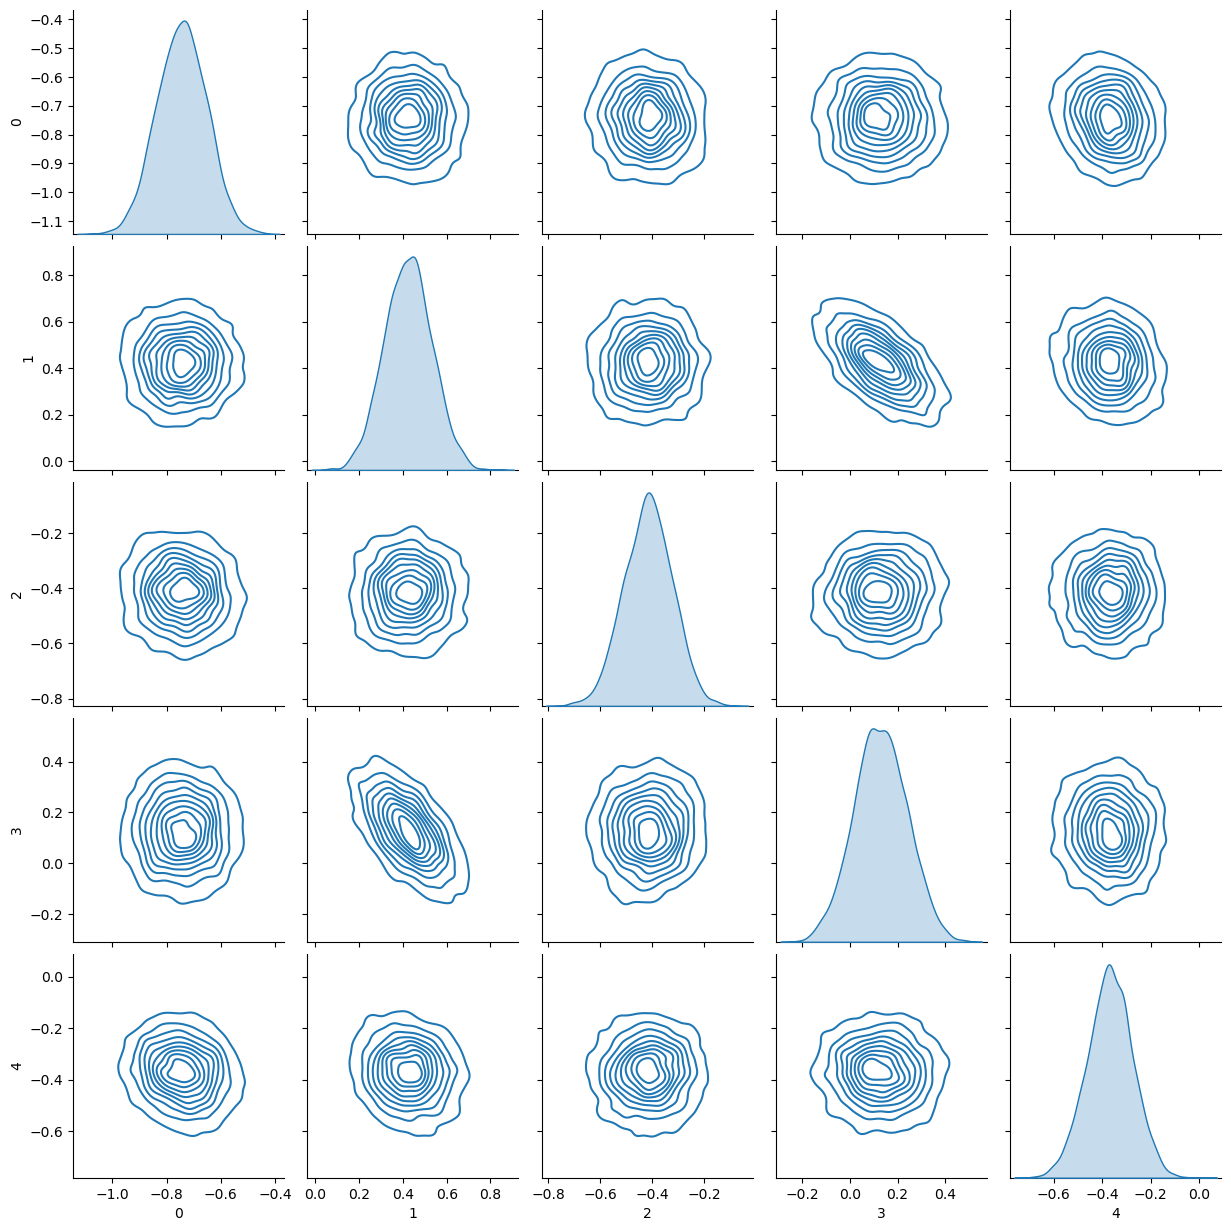

In [47]:
# this cell may take a few minutes to run
sb.pairplot(pd.DataFrame(samples[0][-n_win:,0,:5]), kind='kde')
plt.show()

In [48]:
pos_mean_ests[0]

array([-0.74414126,  0.4241506 , -0.41839217,  0.12710365, -0.36954796,
       -0.18039629, -0.15457362,  0.01327902,  0.18169713, -0.11199728,
       -0.22726602,  0.12531192,  0.08066129, -0.28143959, -1.5794121 ,
        0.66583898, -0.99930186,  1.07159415,  1.39253364,  0.32516213,
       -0.13738912, -0.64252541, -0.06498056, -0.05009144, -2.04270322])